<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/auduvignac/challengedata_ens_AssurPrime/blob/main/notebooks/exploration/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

##Installation de category-encoder

In [1]:
#pip install category-encoders

In [2]:
#pip install -U scikit-learn


##Importation des bibliothèques

In [3]:
#pip install -U xgboost

In [4]:
#pip install -U imblearn

In [5]:
# Importer les bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
from category_encoders import CountEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, fbeta_score, mean_squared_error, make_scorer
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from imblearn.ensemble import EasyEnsembleClassifier

##Chargement des données

In [6]:
# Charger les données
try:
  print("Chargement des données...")
  X_train_url = "https://media.githubusercontent.com/media/auduvignac/challengedata_ens_AssurPrime/refs/heads/main/data/raw/x_train.csv"
  X_train = pd.read_csv(X_train_url)
  y_train_url = "https://media.githubusercontent.com/media/auduvignac/challengedata_ens_AssurPrime/refs/heads/main/data/raw/y_train.csv"
  y_train = pd.read_csv(y_train_url)
  #X_test_url = "https://media.githubusercontent.com/media/auduvignac/challengedata_ens_AssurPrime/refs/heads/main/data/raw/x_test.csv"
  #X_test = pd.read_csv(X_test_url)
  print("Données chargées avec succès.")
except:
  print("Erreur lors du chargement des données. Vérifiez que les URLs sont correctes.")

Chargement des données...


/var/folders/cz/_qd42vtn1nbbcf9dwk6sg5tw0000gn/T/ipykernel_4328/3323000319.py:5: DtypeWarning: Columns (16,17,29,30,31,126,128,129,132,133,135,138,371) have mixed types. Specify dtype option on import or set low_memory=False.
  X_train = pd.read_csv(X_train_url)


Données chargées avec succès.


In [7]:
X_train_init = X_train.copy()
y_train_init = y_train.copy()

##Analyse des données

In [8]:
# Afficher un aperçu des données pour vérifier leur chargement
print("Aperçu de X_train :")
display(X_train_init.head())
print("Aperçu de y_train :")
display(y_train_init.head())
#print("Aperçu de X_test :")
#display(X_test.head())

Aperçu de X_train :


,ID,ACTIVIT2,VOCATION,TYPERS,ANCIENNETE,ADOSS,CARACT1,CARACT2,CARACT3,INDEM1,...,NBJRR100_MMAX_A,NBJRR100_MSOM_A,RR_VOR_MM_A,RR_VOR_MMAX_A,RRAB_VOR_MM_A,RRAB_VOR_MMAX_A,ANNEE_ASSURANCE,ESPINSEE,AN_EXERC,ZONE
0,1,ACT1,VOC6,1,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,ANNEE5,3
1,2,ACT1,VOC6,1,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,ANNEE5,3
2,3,ACT1,VOC6,1,2,N,R,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,0.402740,NaN,ANNEE5,3
3,4,ACT1,VOC6,2,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,0.246575,NaN,ANNEE5,3
4,5,ACT1,VOC6,2,1,N,N,NaN,NaN,N,...,01. <= 0,01. <= 0,03. <= 102,03. <= 232,04. >= 25,02. <= 57,0.838356,NaN,ANNEE5,3


Aperçu de y_train :


,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE
0,1,0.0,0.0,1.000000,0.0
1,2,0.0,0.0,1.000000,0.0
2,3,0.0,0.0,0.402740,0.0
3,4,0.0,0.0,0.246575,0.0
4,5,0.0,0.0,0.838356,0.0


###Aperçu général des données

In [9]:
# 0. Afficher le type des données de X_train
pd.set_option('display.max_rows', None)

print("Types des données de X_train :")
print(X_train_init.dtypes)


Types des données de X_train :
ID                              int64
ACTIVIT2                       object
VOCATION                       object
TYPERS                          int64
ANCIENNETE                      int64
ADOSS                          object
CARACT1                        object
CARACT2                       float64
CARACT3                        object
INDEM1                         object
DUREE_REQANEUF                float64
CARACT4                        object
CARACT5                         int64
TYPBAT1                        object
INDEM2                         object
TYPBAT2                         int64
FRCH1                          object
FRCH2                          object
DEROG1                         object
DEROG2                         object
DEROG3                         object
DEROG4                         object
DEROG5                         object
DEROG6                         object
DEROG7                         object
DEROG8             

###Analyse
Des colonnes qui semblent être de même nature, ne sont pas de même type. Par exemple : Kapitalnn (int64, float64 et object)

Il y a beaucoup de caractéristiques (374) et la plupart sont de type 'object'.

In [10]:
# 2. Calcul des valeurs manquantes
nb_missing = X_train_init.isnull().sum()
taux_missing = X_train_init.isnull().mean() * 100

# Création d'un DataFrame combiné
missing_info = pd.DataFrame({
    'Valeurs manquantes': nb_missing,
    'Taux (%)': taux_missing.round(2)
})

# Filtrage pour ne garder que les colonnes avec au moins une valeur manquante
missing_info = missing_info[missing_info['Valeurs manquantes'] > 0]

print(missing_info)

                            Valeurs manquantes  Taux (%)
CARACT1                                   4633      1.21
CARACT2                                 368284     96.00
CARACT3                                 368284     96.00
DUREE_REQANEUF                           26573      6.93
TYPBAT1                                 353336     92.11
INDEM2                                   27372      7.14
FRCH2                                    26573      6.93
DEROG12                                 349078     91.00
DEROG13                                 382317     99.66
DEROG14                                 383602    100.00
DEROG16                                 380358     99.15
KAPITAL11                               119005     31.02
KAPITAL15                                  624      0.16
KAPITAL16                                 1582      0.41
KAPITAL17                                  889      0.23
KAPITAL18                                   48      0.01
KAPITAL19                      

###Analyse

***Beaucoup de valeurs manquantes** pour bon nombre de caratéristiques. L'enjeu est d'identifier les caractéristiques qui de ce fait n'apprendront rien au modèle pour les écarter et ainsi commencer à réduire le nombre de caractéristiques à prendre en compte.*

***Par exemple :** DEROGnn a plus de 380000 valeurs manquantes sur 383610 lignes, soit 99% de valeurs manquantes. A minima pour prédire la frequence du risque incendie on peut considérer les caractérisques DEROGnn comme inutiles.*

Il convient d'arbitrer pour chaque caractéristique, fonction de la cible à prédire (Freq ou CN). Pour cela nous allons dans un premier temps calculer le taux de valeurs manquantes.

In [11]:
# 3. Analyse des valeurs uniques
unique_values = X_train_init.nunique()
print("\nNombre de valeurs uniques par colonne :")
print(unique_values)


Nombre de valeurs uniques par colonne :
ID                            383610
ACTIVIT2                           9
VOCATION                           8
TYPERS                             2
ANCIENNETE                        12
ADOSS                              2
CARACT1                            3
CARACT2                            2
CARACT3                            3
INDEM1                             2
DUREE_REQANEUF                     4
CARACT4                            6
CARACT5                           16
TYPBAT1                            5
INDEM2                            12
TYPBAT2                            3
FRCH1                              9
FRCH2                              6
DEROG1                             2
DEROG2                             2
DEROG3                             2
DEROG4                             2
DEROG5                             2
DEROG6                             2
DEROG7                             2
DEROG8                            

###Analyse

On constate que beaucoup de caractéristiques ont un nombre de valeurs uniques limité (par exemple 4) et sont de type object. La table de contingence ci-dessous permet de constater que ces caractéristiques prennent pour valeur des plages de valeurs ("<= nn" ou ">= nn").

Pour les caclculs des modèles, il nous faut convertir ces objects en catégories numériques.

In [12]:
# 4. Table de contingence pour les variables catégorielles
categorical_cols = X_train_init.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    print(f"\nTable de contingence pour {col} :")
    print(X_train_init[col].value_counts())


Table de contingence pour ACTIVIT2 :
ACTIVIT2
ACT1    296563
ACT5     53709
ACT2     14359
ACT8      5650
ACT3      5335
ACT9      4459
ACT7      2201
ACT6      1007
ACT4       327
Name: count, dtype: int64

Table de contingence pour VOCATION :
VOCATION
VOC6    244441
VOC8     67446
VOC7     38967
VOC4     15289
VOC1     14359
VOC2      1952
VOC3      1081
VOC5        75
Name: count, dtype: int64

Table de contingence pour ADOSS :
ADOSS
N    375557
O      8053
Name: count, dtype: int64

Table de contingence pour CARACT1 :
CARACT1
N    274335
R     93158
O     11484
Name: count, dtype: int64

Table de contingence pour CARACT3 :
CARACT3
N    7433
O    6795
R    1098
Name: count, dtype: int64

Table de contingence pour INDEM1 :
INDEM1
N    365728
O     17882
Name: count, dtype: int64

Table de contingence pour CARACT4 :
CARACT4
absence de surface    365009
Surface de moins d     10343
Surface entre 501       5205
Surface entre 1001      1600
Surface entre 1501       933
Surface de plus d

In [13]:
# 1. Aperçu des données - informations statistiques
print("\nAperçu des données :")
print(X_train_init.info())
#print("\nRésumé statistique :")
#print(X_train.describe(include='all'))



Aperçu des données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383610 entries, 0 to 383609
Columns: 374 entries, ID to ZONE
dtypes: float64(36), int64(58), object(280)
memory usage: 1.1+ GB
None


#En savoir davantage sur la cible finale CHARGE.
On sait que CHARGE = 0 dans 99% des cas. Nous voulons savoir à quoi ressemblent les 1% où CHARGE > 0

In [14]:
# Calcul des statistiques sur y_train['CHARGE'] pour les valeurs strictement positives
charge_pos = y_train_init.loc[y_train['CHARGE'] > 0, 'CHARGE']
mean_charge = charge_pos.mean()
min_charge = charge_pos.min()
max_charge = charge_pos.max()

print(f"Valeur moyenne de CHARGE (>0): {mean_charge}")
print(f"Valeur minimale de CHARGE (>0): {min_charge}")
print(f"Valeur maximale de CHARGE (>0): {max_charge}")

Valeur moyenne de CHARGE (>0): 30356.59975765306
Valeur minimale de CHARGE (>0): 1.0
Valeur maximale de CHARGE (>0): 552000.0


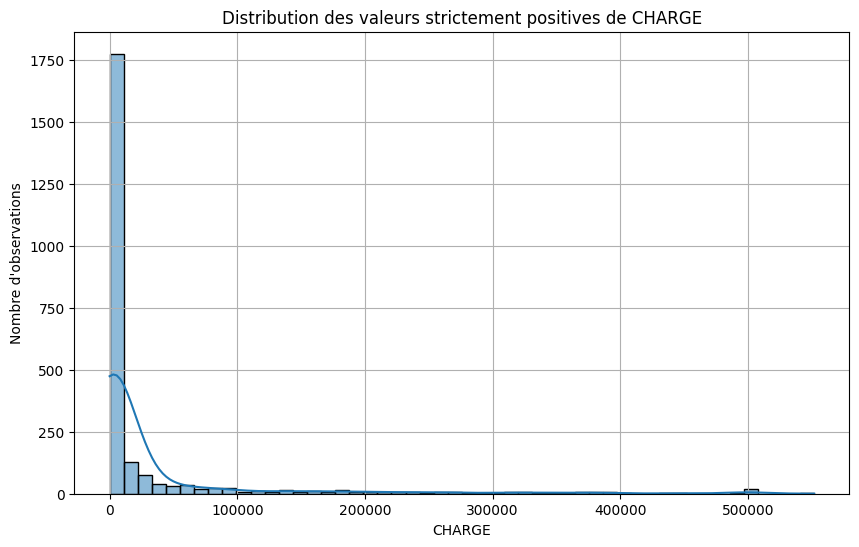

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(charge_pos, bins=50, kde=True)
plt.xlabel("CHARGE")
plt.ylabel("Nombre d'observations")
plt.title("Distribution des valeurs strictement positives de CHARGE")
plt.grid(True)
plt.show()

In [16]:
# Calcul des déciles de la distribution de y_train['CHARGE']
deciles = y_train_init.loc[y_train['CHARGE'] > 0, 'CHARGE'].quantile(np.arange(0, 1.1, 0.1))
print("Déciles de la variable CHARGE :")
print(deciles)

Déciles de la variable CHARGE :
0.0         1.000
0.1       250.000
0.2       400.000
0.3       600.000
0.4      1034.002
0.5      1800.000
0.6      3336.748
0.7      6923.919
0.8     19757.416
0.9     84994.395
1.0    552000.000
Name: CHARGE, dtype: float64


#Qu'en est-il de FREQ ?

In [17]:
# Calcul des statistiques sur y_train['CHARGE'] pour les valeurs strictement positives
freq_pos = y_train_init.loc[y_train_init['FREQ'] > 0, 'FREQ']
mean_freq = freq_pos.mean()
min_freq = freq_pos.min()
max_freq = freq_pos.max()

print(f"Valeur moyenne de FREQ (>0): {mean_freq}")
print(f"Valeur minimale de FREQ (>0): {min_freq}")
print(f"Valeur maximale de FREQ (>0): {max_freq}")

Valeur moyenne de FREQ (>0): 1.6505329128117547
Valeur minimale de FREQ (>0): 0.9681697613001744
Valeur maximale de FREQ (>0): 182.49999849437503


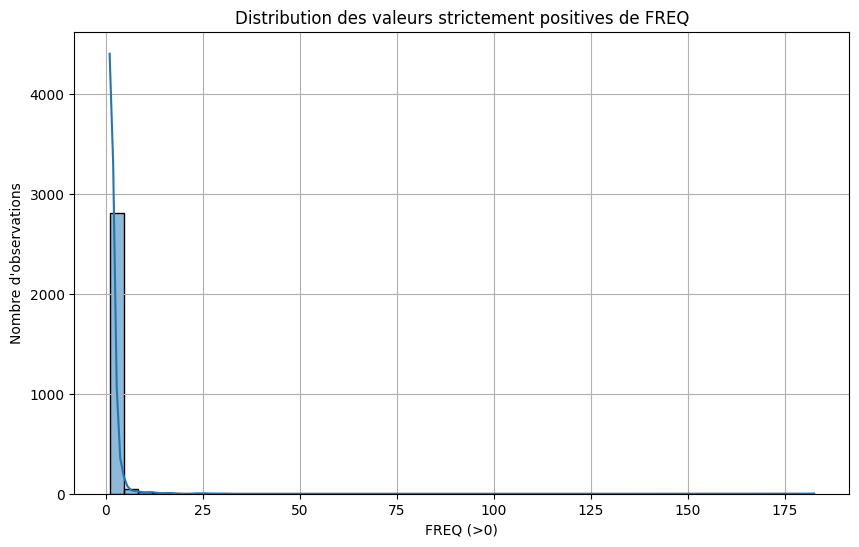

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(freq_pos, bins=50, kde=True)
plt.xlabel("FREQ (>0)")
plt.ylabel("Nombre d'observations")
plt.title("Distribution des valeurs strictement positives de FREQ")
plt.grid(True)
plt.show()

#Examinons à présent la distribution des coûts moyens lorsqu'ils sont différents de 0

In [19]:
# Calcul des statistiques sur y_train['CHARGE'] pour les valeurs strictement positives
cm_pos = y_train_init.loc[y_train_init['CM'] > 0, 'CM']
mean_cm= freq_pos.mean()
min_cm = freq_pos.min()
max_cm = freq_pos.max()

print(f"Valeur moyenne de FREQ (>0): {mean_cm}")
print(f"Valeur minimale de FREQ (>0): {min_cm}")
print(f"Valeur maximale de FREQ (>0): {max_cm}")

Valeur moyenne de FREQ (>0): 1.6505329128117547
Valeur minimale de FREQ (>0): 0.9681697613001744
Valeur maximale de FREQ (>0): 182.49999849437503


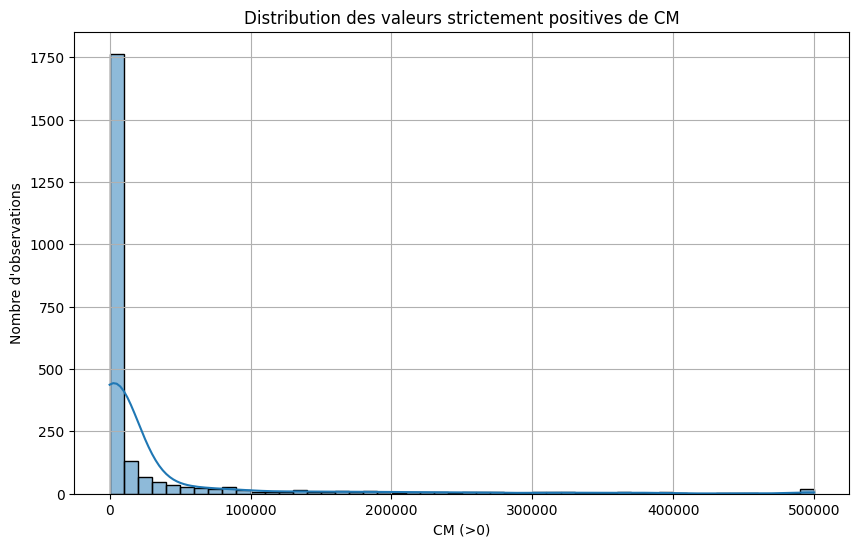

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(cm_pos, bins=50, kde=True)
plt.xlabel("CM (>0)")
plt.ylabel("Nombre d'observations")
plt.title("Distribution des valeurs strictement positives de CM")
plt.grid(True)
plt.show()

#Regardons ce que donnent des transformations des variables cibles FREQ et CM

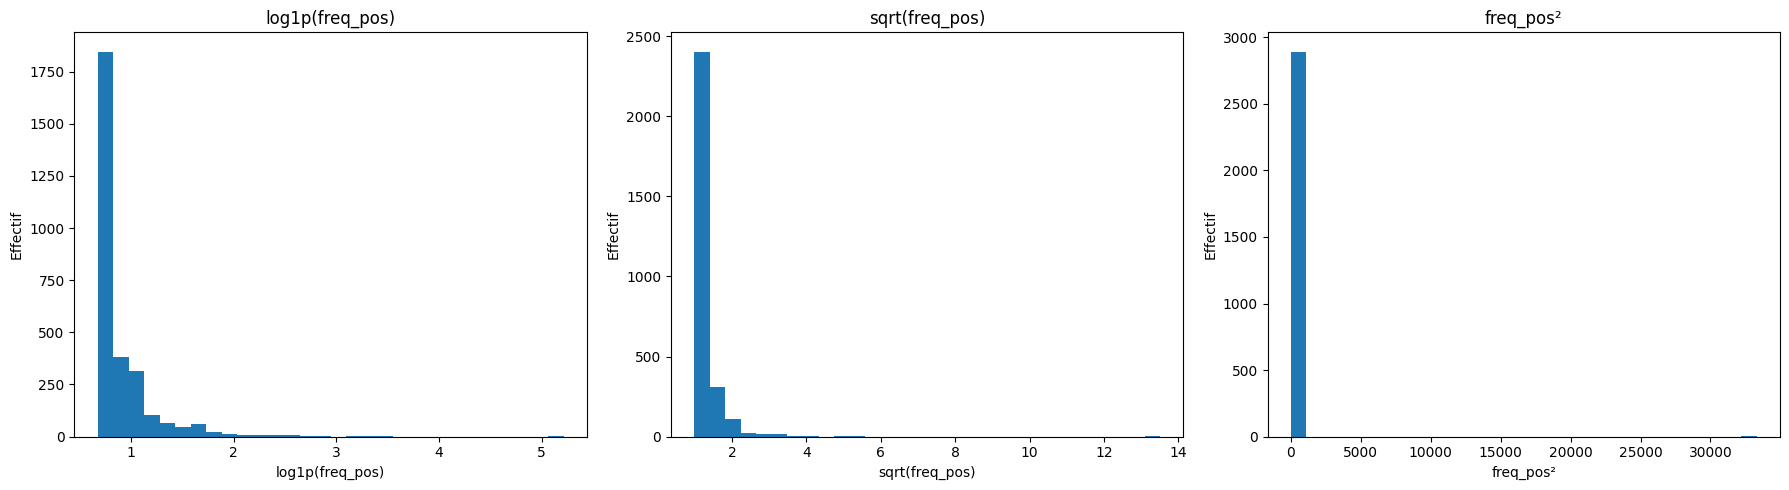

In [21]:
# Visualisation de la distribution de la variable 'freq_pos' après transformation

# Calcule des trois transformations
log_freq    = np.log1p(freq_pos)      # log(1 + freq_pos) pour gérer les zéros
sqrt_freq   = np.sqrt(freq_pos)       # racine carrée
square_freq = freq_pos ** 2           # carré

# Création de la figure et des sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogramme de log(freq_pos)
axes[0].hist(log_freq, bins=30)
axes[0].set_title('log1p(freq_pos)')
axes[0].set_xlabel('log1p(freq_pos)')
axes[0].set_ylabel('Effectif')

# Histogramme de sqrt(freq_pos)
axes[1].hist(sqrt_freq, bins=30)
axes[1].set_title('sqrt(freq_pos)')
axes[1].set_xlabel('sqrt(freq_pos)')
axes[1].set_ylabel('Effectif')

# Histogramme de (freq_pos)**2
axes[2].hist(square_freq, bins=30)
axes[2].set_title('freq_pos²')
axes[2].set_xlabel('freq_pos²')
axes[2].set_ylabel('Effectif')

plt.tight_layout()
plt.show()


#Regardons l'effet des transformations sur CM

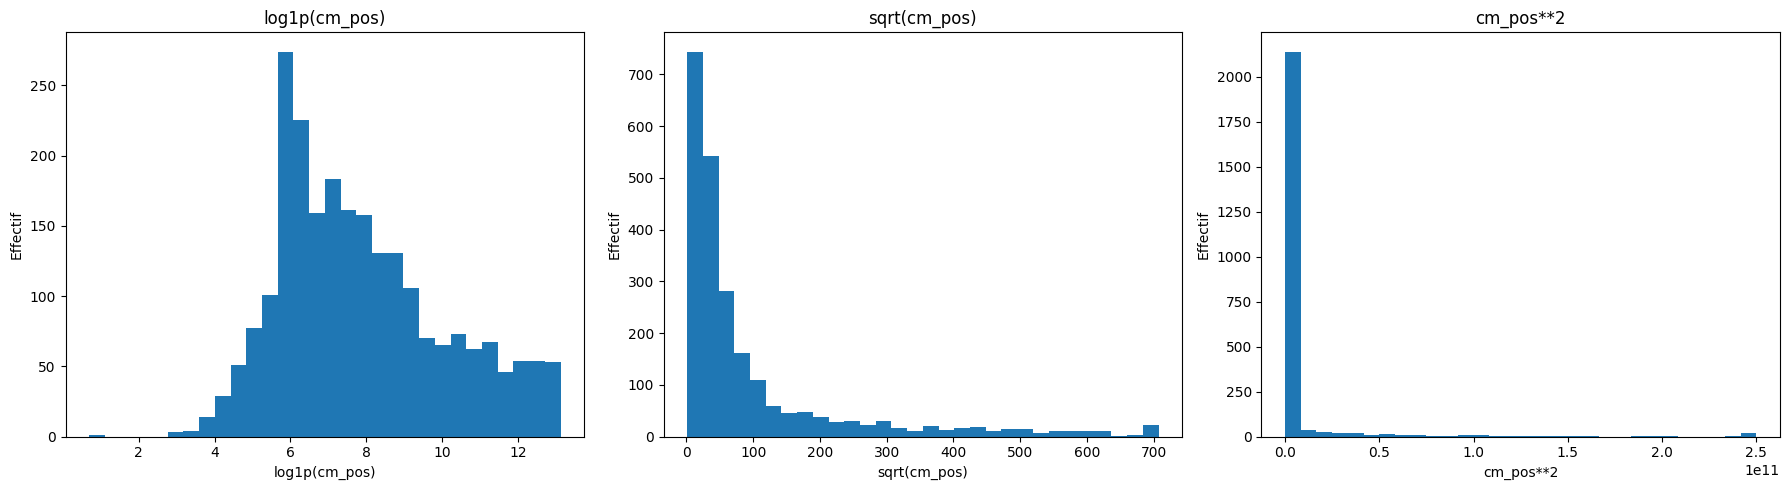

In [22]:
# Visualisation de la distribution de la variable 'cm_pos' après transformation

# Calcule des trois transformations
log_cm   = np.log1p(cm_pos)      # log(1 + cm_pos) pour gérer les zéros
sqrt_cm   = np.sqrt(cm_pos)       # racine carrée
square_cm= cm_pos ** 2           # carré

# Création de la figure et des sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogramme de log(cm_pos)
axes[0].hist(log_cm, bins=30)
axes[0].set_title('log1p(cm_pos)')
axes[0].set_xlabel('log1p(cm_pos)')
axes[0].set_ylabel('Effectif')

# Histogramme de sqrt(cm_pos)
axes[1].hist(sqrt_cm, bins=30)
axes[1].set_title('sqrt(cm_pos)')
axes[1].set_xlabel('sqrt(cm_pos)')
axes[1].set_ylabel('Effectif')

# Histogramme de (cm_pos)**2
axes[2].hist(square_cm, bins=30)
axes[2].set_title('cm_pos**2')
axes[2].set_xlabel('cm_pos**2')
axes[2].set_ylabel('Effectif')

plt.tight_layout()
plt.show()


#Réduction du nombre de données
Trop de variables et particulièrement trop de variables météorologiques. Nous faisons l'hypothèse que seules les valeurs extrêmes ont un impact sur le risque incendie : forte chaleur durable + secheresse (humidité faible) + vents forts.
Pour cela nous llons créer trois variables qui auront pour rôle de catégoriser ces extrêmes et nous permettront de supprimer toutes les données météorologiques détaillées.

In [23]:
# les colonnes ordinales météo sous forme de chaînes "01", "02", "03", "04"
# ou avec un préfixe type "01. <= 44". On extrait dans ce cas les 2 premiers caractères.

# 1. Catégorie température (chaud / froid)
# On choisit ici NBJTX25_MSOM_A : total annuel de jours TX > 25 °C
# 01–02 → froid, 03–04 → chaud
temp_map = {
    "01": "froid",
    "02": "froid",
    "03": "chaud",
    "04": "chaud",
}
X_train_init["temp_category"] = (
    X_train_init["NBJTX25_MMAX_A"]
    .astype(str)
    .str[:2]
    .map(temp_map)
    .fillna("inconnu")  # au cas où une modalité inattendue apparaisse
)

# 2. Catégorie pluviométrie (humide / sec)
# On prend NBJRR1_MSOM_A : total annuel de jours avec RR ≥ 1 mm
# 01–02 → sec, 03–04 → humide
rain_map = {
    "01": "humide",
    "02": "humide",
    "03": "sec",
    "04": "sec",
}
X_train_init["rain_category"] = (
    X_train_init["NBJRR1_MMAX_A"]
    .astype(str)
    .str[:2]
    .map(rain_map)
    .fillna("inconnu")
)

# 3. Catégorie vent (faible / fort)
# On utilise FFM_VOR_MM_A : variabilité mensuelle moyenne du vent
# 01–02 → faible, 03–04 → fort
wind_map = {
    "01": "faible",
    "02": "faible",
    "03": "fort",
    "04": "fort",
}
X_train_init["wind_category"] = (
    X_train_init["FFM_VOR_MMAX_A"]
    .astype(str)
    .str[:2]
    .map(wind_map)
    .fillna("inconnu")
)

# Vérification rapide
print(X_train_init[["temp_category", "rain_category", "wind_category"]].head())


  temp_category rain_category wind_category
0       inconnu       inconnu       inconnu
1       inconnu       inconnu       inconnu
2       inconnu       inconnu       inconnu
3       inconnu       inconnu       inconnu
4         chaud           sec        faible


In [24]:
# Suppression des colonnes météo
# On va supprimer toutes les colonnes météo pour ne garder que les variables de score
# et les autres variables d'intérêt.
# On va d'abord identifier les colonnes météo à supprimer
# en se basant sur les préfixes typiques des features météo.
# On va ensuite supprimer ces colonnes de notre DataFrame
# et ne garder que les colonnes restantes (celles qui ne sont pas météo).


# 1. Liste des préfixes typiques des features météo
meteo_prefixes = (
    "NBJ",     # NBJTX*, NBJTN*, NBJRR*, etc.
    "FFM_",    # FFM_VOR_*
    "FXI",     # FXI3SAB_*, FXIAB_VOR_*
    "FXY",     # FXYAB_VOR_*
    "TMM",     # TMMIN_VOR_*, TMMAX_VOR_*, TMM_VOR_*
    "TM_",     # TM_VOR_*
    "TN",      # TNMIN*, TNMAX_VOR_*, TNAB_VOR_*
    "TX",      # TXMIN_VOR_*, TXAB_VOR_*
    "RR_",     # RR_VOR_*, RRAB_VOR_*
    "TAMP",
    "RRAB"
)

# 2. Identifier automatiquement toutes les colonnes météo
meteo_cols = [
    col for col in X_train_init.columns
    if col.startswith(meteo_prefixes)
]

# 3. Supprimer ces colonnes
X_train_prep = X_train_init.drop(columns=meteo_cols)

# 4. Afficher les colonnes supprimées et restantes

print("Colonnes météo supprimées :", meteo_cols)
print("Colonnes restantes :", X_train_prep.columns.tolist())


Colonnes météo supprimées : ['NBJTX25_MM_A', 'NBJTX25_MMAX_A', 'NBJTX25_MSOM_A', 'NBJTX0_MM_A', 'NBJTX0_MMAX_A', 'NBJTX0_MSOM_A', 'NBJTXI27_MM_A', 'NBJTXI27_MMAX_A', 'NBJTXI27_MSOM_A', 'NBJTXS32_MM_A', 'NBJTXS32_MMAX_A', 'NBJTXS32_MSOM_A', 'NBJTXI20_MM_A', 'NBJTXI20_MMAX_A', 'NBJTXI20_MSOM_A', 'NBJTX30_MM_A', 'NBJTX30_MMAX_A', 'NBJTX30_MSOM_A', 'NBJTX35_MM_A', 'NBJTX35_MMAX_A', 'NBJTX35_MSOM_A', 'NBJTN10_MM_A', 'NBJTN10_MMAX_A', 'NBJTN10_MSOM_A', 'NBJTNI10_MM_A', 'NBJTNI10_MMAX_A', 'NBJTNI10_MSOM_A', 'NBJTN5_MM_A', 'NBJTN5_MMAX_A', 'NBJTN5_MSOM_A', 'NBJTNS25_MM_A', 'NBJTNS25_MMAX_A', 'NBJTNS25_MSOM_A', 'NBJTNI15_MM_A', 'NBJTNI15_MMAX_A', 'NBJTNI15_MSOM_A', 'NBJTNI20_MM_A', 'NBJTNI20_MMAX_A', 'NBJTNI20_MSOM_A', 'NBJTNS20_MM_A', 'NBJTNS20_MMAX_A', 'NBJTNS20_MSOM_A', 'NBJTMS24_MM_A', 'NBJTMS24_MMAX_A', 'NBJTMS24_MSOM_A', 'TAMPLIAB_VOR_MM_A', 'TAMPLIAB_VOR_MMAX_A', 'TAMPLIM_VOR_MM_A', 'TAMPLIM_VOR_MMAX_A', 'TM_VOR_MM_A', 'TM_VOR_MMAX_A', 'TMM_VOR_MM_A', 'TMM_VOR_MMAX_A', 'TMMAX_VOR_MM_A', 

En sortie : X_train_prep et y_train_init

##Traitement des valeurs manquantes

In [25]:
# Traitement des valeurs manquantes dans les colonnes numériques
print("Traitement des valeurs manquantes dans les colonnes numériques...")
numeric_columns = X_train_prep.select_dtypes(include=['number']).columns

# Remplir les NaN avec 0 pour les colonnes numériques
X_train_prep[numeric_columns] = X_train_prep[numeric_columns].fillna(0)

# Identifier les colonnes non numériques
fill_cols = [item for item in X_train_prep.columns if item not in numeric_columns]

# Remplir les NaN des colonnes non numériques avec une valeur par défaut (-999)
X_train_prep[fill_cols] = X_train_prep[fill_cols].fillna(-999)

print("Traitement des valeurs manquantes terminé.")

Traitement des valeurs manquantes dans les colonnes numériques...
Traitement des valeurs manquantes terminé.


##Encodage des variables catégorielles.
Afin de normaliser les variables, nous choisissons de faire un encodage en fréquence. Pour cela nous utilisons la fonction CountEncoder avec le paramètre normalize=True

In [26]:
# Préparation des données pour l'entraînement
print("Préparation des données pour l'entraînement...")

# Suppression des colonnes inutiles
X_train_prep = X_train_prep.drop(['ID', 'ANNEE_ASSURANCE'], axis=1)

# Encodage des variables catégoriques avec CountEncoder
encoder = CountEncoder(cols=fill_cols, normalize=True)
encoder.fit(X_train_prep)
X_train_enc = encoder.transform(X_train_prep)

print("Préparation terminée.")

Préparation des données pour l'entraînement...
Préparation terminée.


Sortie X_train_enc et y_train_init

##Traitement des outliers

Nous avons remarqué que CM a pour 6 lignes des valeurs négatives. Ceci n'a pas de sens pour une valeur qui correspond à un coût moyen. Il s'agit sans doute d'erreurs qui risques de biaiser l'apprentissage des modèles. Compte tenu du très faible nombre de cas, nous décidons de filtrer ces lignes.

De même pour FREQ, les deux plus grandes valeurs sont 30 et 180. On considère que 180 est une valeur anormale et choisissons de filtrer ces cas extrême pour les apprentissages.

En sortie nous avons un jeu de données encodé et filtré.

In [27]:
# Filtrer les lignes où y_train['CM'] < 0 ou y_train['FREQ'] > 100
mask = (y_train_init['CM'] >= 0) & (y_train_init['FREQ'] <= 100)

# Appliquer le masque pour filtrer les données
X_train_enc_filtered = X_train_enc[mask]
y_train_filtered = y_train_init[mask]

print(f"Nombre de lignes après filtrage : {len(X_train_enc_filtered)}")

Nombre de lignes après filtrage : 383603


En sortie X_train_enc_filtered et y_train_filtered

#Séparation d'un jeu de train et de test

Pour la bonne évaluation des modèles et leur choix, nous séparation le jeu de données en un jeu d'entrainement 80% et un jeu de test 20%

In [28]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train_enc_filtered, y_train_filtered, stratify=y_train_filtered['FREQ']>0,test_size=0.2, random_state=42
)

#Preparation des datasets filtrés sur FREQ>0 pour les entrainements de prédiction de FREQ et CM

Nous observons que 380716 lignes ont une valeur FREQ = 0.

Nous sommes donc dans le cas d'une base de données des contrats d'assurance qui ne recense que les sinsitres incendies, pour laquelle sur 383610 contrats, 380716 n'ont eu aucun sinistres et donc aucun coût de sinistre.

Heureusement, s'agissant d'une assurance, moins de 1% des contrats ont connu un sinistre incendie.

A noter que 536 contrats (381252 - 380716) ont eu un sinistre dont le coût moyen CM est égal à zéro. Il peut s'agir de sinistres dont le coût est inférieur à des franchises. Il nous semble intéressant de préserver ces cas dans l'apprentissage des CM.

A noter également que sur les 2894 contrats qui ont eu FREQ > 0 il y en a 1446 dont la FREQ = 1.

Compte tenu de la distribution de FREQ qui montre un très grand déséquilibre entre le nombre de lignes avec FREQ=0 (99%) et FREQ>0 (1%) il nous semble nécessaire d'organiser un pipeline bassé sur 3 modèles.

Un modèle de classification binaire, permettant de séparer les lignes FREQ=0 dont la prédiction est simple, de celle où FREQ>0.
Suivi de deux modèles de regression linéaire pour prédire FREQ lorsque FREQ>0 et CM lorsque FREQ>0. Pour ce dernier nous préférons faire l'entrainement sur les données filtrées sur FREQ>0 et non pas CM>0, car il y a des cas où FREQ>0 (il y a donc eu un sinistre de déclaré) et CM=0 (potentiellement dû à des spécificités du contrat comme par exemple l'application de franchises) et nous souhaitons capter aussi ces cas pour la prédiction.

In [29]:
X_train_split_pos = X_train_split[y_train_split['FREQ'] > 0]
y_train_split_pos = y_train_split[y_train_split['FREQ'] > 0]
X_test_split_pos = X_test_split[y_test_split['FREQ'] > 0]
y_test_split_pos = y_test_split[y_test_split['FREQ'] > 0]

y_train_split_binary = (y_train_split['FREQ'] > 0).astype(int)
y_test_split_binary = (y_test_split['FREQ'] > 0).astype(int)

print("X_pos : ",X_train_split_pos.shape, "y_pos : ",y_train_split_pos.shape)
print("X_test_pos : ",X_test_split_pos.shape, "y_test_pos : ",y_test_split_pos.shape)
print("y_train_split_binary : ",y_train_split_binary.shape)
print("y_test_split_binary : ",y_test_split_binary.shape)
# Normalisation des données

X_pos :  (2310, 245) y_pos :  (2310, 5)
X_test_pos :  (577, 245) y_test_pos :  (577, 5)
y_train_split_binary :  (306882,)
y_test_split_binary :  (76721,)


###Fonction de classification et fonction de calcul du seuil optimal pour la classification binaire
L'imbalance est très important dans cette classification puisque 99% des observation appartiennent à une classe et 1% à l'autre classe. Le seuil de 0,5 pris par défaut n'est pas nécessairement le meilleur dans ce cas pour avoir un bon recall des FREQ > 0 en préservant une précision acceptable.

Cette fonction cherche le meilleur compromis.

#Comparaison de modèles de classification binaire pour séparer les FREQ = 0 des FREQ > 0

In [30]:
# Fonction de calcul du seuil optimal lors de la classification binaire

def find_best_threshold(y_true, y_proba, beta=2, thresholds=np.linspace(0.01, 0.99, 200)): 
    best_thresh, best_score = 0, 0
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        score = fbeta_score(y_true, y_pred, beta=beta)
        if score > best_score:
            best_thresh, best_score = t, score
    return best_thresh, best_score

##Pour le premier étage du pipeline de modèlisation nous allons comparer trois modèles : XGBClassifier, RadomForestClassifier et un LogisticRegression

Dans un secon temps après le choix du modèle, nous chercherons avec un gridsearch les meilleurs paramètres pour le modèle choisi.


===== XGBoost =====
Meilleur seuil F2: 0.62 → F2-score: 0.103
              precision    recall  f1-score   support

           0      0.994     0.951     0.972    304572
           1      0.033     0.219     0.058      2310

    accuracy                          0.946    306882
   macro avg      0.513     0.585     0.515    306882
weighted avg      0.987     0.946     0.965    306882


===== RandomForest =====
Meilleur seuil F2: 0.66 → F2-score: 0.113
              precision    recall  f1-score   support

           0      0.994     0.958     0.976    304572
           1      0.039     0.220     0.066      2310

    accuracy                          0.953    306882
   macro avg      0.516     0.589     0.521    306882
weighted avg      0.987     0.953     0.969    306882



/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



===== LogisticRegression =====
Meilleur seuil F2: 0.71 → F2-score: 0.086
              precision    recall  f1-score   support

           0      0.994     0.920     0.955    304572
           1      0.023     0.255     0.043      2310

    accuracy                          0.915    306882
   macro avg      0.509     0.587     0.499    306882
weighted avg      0.987     0.915     0.949    306882



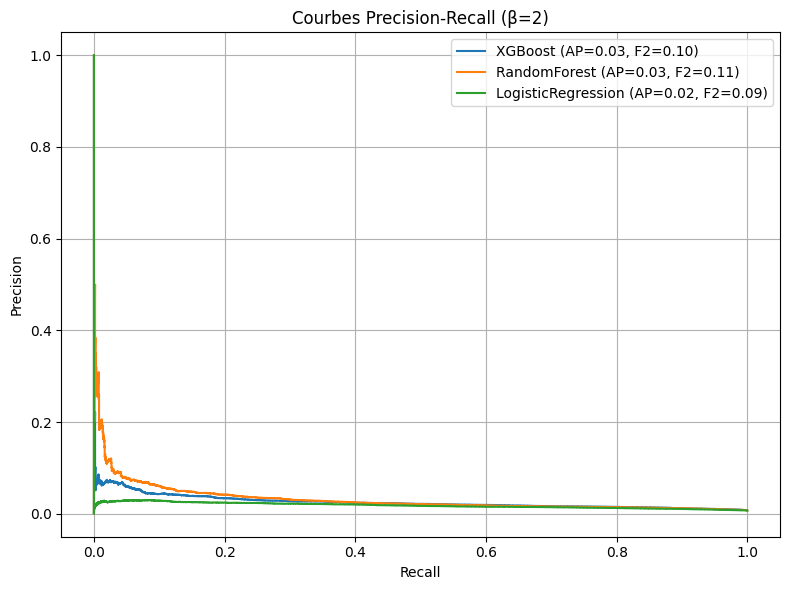

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
import matplotlib.pyplot as plt

# Définition des modèles à tester
models = {
    'XGBoost': XGBClassifier(
        use_label_encoder=False,
        objective='binary:logistic',
        eval_metric='aucpr',
        scale_pos_weight=99,  # 99 par défaut
        n_estimators=200,
        max_depth=4,
        learning_rate=0.01,
        subsample=0.72,
        colsample_bytree=0.7,
        n_jobs=-1,
        verbosity=0,
        random_state=42
    ),
    'RandomForest': RandomForestClassifier(
    n_estimators=900,              # plus d'arbres pour réduire variance
    max_depth=6,                   # restreint pour limiter l'overfitting
    min_samples_split=20,          # évite les splits sur trop peu de minorités
    min_samples_leaf=5,            # feuilles plus robustes
    max_features='log2',           # bon compromis bias/variance
    class_weight='balanced_subsample', # rééquilibrage par arbre
    max_samples=0.8,               # échantillonnage aléatoire
    oob_score=True,
    n_jobs=-1,
    random_state=42
),
    'LogisticRegression': LogisticRegression(
        class_weight='balanced',
        solver='lbfgs',        
        max_iter=1000,
        random_state=42
    )
}

def evaluate_models(X, y_df, models, beta=2):
    """
    Entraîne chaque modèle, recherche le meilleur seuil pour F_beta,
    affiche le classification_report et trace les courbes precision-recall.
    """
    # Binarisation de la cible
    y_true = (y_df['FREQ'] > 0).astype(int)

    plt.figure(figsize=(8, 6))
    results = {}

    for name, clf in models.items():
        # Entraînement
        clf.fit(X, y_true)

        # Probabilités positives
        y_proba = clf.predict_proba(X)[:, 1]

        # Recherche du meilleur seuil F_beta
        thresh, fbeta = find_best_threshold(y_true, y_proba, beta=beta)
        
        # Calcul de la courbe PR et de l’Average Precision
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        ap = average_precision_score(y_true, y_proba)

        # Tracé de la courbe
        plt.plot(recall, precision, label=f"{name} (AP={ap:.2f}, F{beta}={fbeta:.2f})")

        # Rapport de classification au seuil optimal
        y_pred = (y_proba >= thresh).astype(int)
        print(f"\n===== {name} =====")
        print(f"Meilleur seuil F{beta}: {thresh:.2f} → F{beta}-score: {fbeta:.3f}")
        print(classification_report(y_true, y_pred, digits=3))

        results[name] = {'threshold': thresh, 'fbeta': fbeta, 'ap': ap}

    # Mise en forme du graphe
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Courbes Precision-Recall (β={beta})')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

# Exemple d’appel après votre préparation de X_train_enc et y_train
results = evaluate_models(X_train_split, y_train_split, models, beta=2)


##Analyse des résultats

Les résultats de la comparaison de modèles montrent une assez faible capacité à classifier notre jeu de données quel que soit le modèle. Toutefois parmi ces trois modèles, le RandomForest tire un tout petit peu mieux son épingle du jeu.
Nous allons donc conserver ce modèle pour la classification en essayant d'optimiser ses paramètres avec un gridsearch.

In [32]:
param_grid_clf = {
    'max_depth': [5, 6],
    'n_estimators': [700, 800, 900],
    'min_samples_split': [15, 20],
    'min_samples_leaf': [5],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced_subsample'],
    'max_samples': [0.8],
    'oob_score': [True],
    'n_jobs': [-1]
}



def train_classifier(X, y_binary, param_grid, gridsearch=False, scale_pos_weight=99):
    
    if gridsearch:
      clf = RandomForestClassifier(random_state=42)
      search_clf = GridSearchCV(clf, param_grid, scoring='neg_log_loss', cv=3, verbose=0)
      search_clf.fit(X, y_binary)
      clf = search_clf.best_estimator_
      print("Meilleurs paramètres Classifieur:", search_clf.best_params_)

    else:   
        clf = RandomForestClassifier(
        n_estimators=900,              # plus d'arbres pour réduire variance
        max_depth=6,                   # restreint pour limiter l'overfitting
        min_samples_split=20,          # évite les splits sur trop peu de minorités
        min_samples_leaf=5,            # feuilles plus robustes
        max_features='log2',           # bon compromis bias/variance
        class_weight='balanced_subsample', # rééquilibrage par arbre
        max_samples=0.8,               # échantillonnage aléatoire
        oob_score=True,
        n_jobs=-1,
        random_state=42
        )

        clf.fit(X, y_binary)
        print("Paramètres du Classifieur:", clf.get_params())
    return clf

#rfc = train_classifier(X_train_split, y_train_split_binary, param_grid_clf, gridsearch=False)

##Analyse

L'exécution du modèle avec l'option gridsearch=True (temps d'execution d'environ 40 mn) donne les préférence suivantes :
max_depth = 6
n_estimators = 900
min_samples_split = 20
max_features = 'log2'

Nous conservons ces paramètres.

#Section de regression pour la prédiction de FREQ

Comparaison de plusieurs modèles pour prédire FREQ lorsque FREQ>0. Pour cela nous testons un TweedieRegressor, un XGBRegressor et un MLPRegressor.

In [34]:
from typing import Dict, Any, Tuple
import numpy as np
import random
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.linear_model import TweedieRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_freq_regression_models(
    X_train, y_train,
    X_test, y_test,
    cv: int = 5,
    scoring: str = 'neg_mean_absolute_error',
    random_state: int = 42
) -> Tuple[Dict[str, Dict[str, float]], Dict[str, Any]]:
    """
    Entraîne et évalue trois modèles de régression pour prédire FREQ
    (GLM, XGB, MLP) avec GridSearchCV et retourne les métriques & les meilleurs estimateurs.
    """

    # 0) Seed globale
    np.random.seed(random_state)
    random.seed(random_state)

    # 1) Splitter CV déterministe
    cv_split = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    # 2) Pipelines (sans random_state pour Tweedie)
    pipe_glm = Pipeline([('glm', TweedieRegressor())])

    pipe_xgb = Pipeline([('xgb', XGBRegressor(
        objective='count:poisson', n_jobs=-1,
        eval_metric='mae', random_state=random_state
    ))])
    
    pipe_mlp = Pipeline([('mlp', MLPRegressor(
        max_iter=500, random_state=random_state
    ))])


    # 3) Grilles d’hyper-paramètres
    param_grid_glm = {
        'glm__power': [1.5, 1.8, 2.0],
        'glm__alpha': [0.01, 0.1, 1.0]
    }
    param_grid_xgb = {
        'xgb__n_estimators': [100, 300],
        'xgb__learning_rate': [0.01, 0.1],
        'xgb__max_depth': [3, 6]
    }
    param_grid_mlp = {
        'mlp__hidden_layer_sizes': [(50,50), (100,)],
        'mlp__alpha': [1e-4, 1e-3],
        'mlp__learning_rate_init': [1e-3, 1e-2]
    }

    # 4) GridSearchCV avec cv_split
    gs_glm = GridSearchCV(pipe_glm, param_grid_glm, cv=cv_split,
                          scoring=scoring, n_jobs=-1)
    gs_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=cv_split,
                          scoring=scoring, n_jobs=-1)
    gs_mlp = GridSearchCV(pipe_mlp, param_grid_mlp, cv=cv_split,
                          scoring=scoring, n_jobs=-1)

    # 5) Entraînement
    print("Training GLM...")
    gs_glm.fit(X_train, y_train)
    print("Training XGB...")
    gs_xgb.fit(X_train, y_train)
    print("Training MLP...")
    gs_mlp.fit(X_train, y_train)

    # 6) Meilleurs estimateurs
    best_models = {
        'GLM': gs_glm.best_estimator_,
        'XGB': gs_xgb.best_estimator_,
        'MLP': gs_mlp.best_estimator_
    }

    # 7) Évaluation
    results: Dict[str, Dict[str, float]] = {}
    for name, model in best_models.items():
        y_pred = model.predict(X_test)
        mae  = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[name] = {'MAE': mae, 'RMSE': rmse}
        print(f"{name} → MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    return results, best_models


In [35]:
results, best_models = evaluate_freq_regression_models(
    X_train_split_pos, y_train_split_pos['FREQ'],
    X_test_split_pos,  y_test_split_pos['FREQ']
)


Training GLM...


/opt/homebrew/lib/python3.11/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/opt/homebrew/lib/python3.11/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/opt/homebrew/lib/python3.11/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/opt/homebrew/lib/python3.11/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/opt/homebrew/lib/python3.11/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/opt/homebrew/lib/python3.11/site-packages/numpy/_core/_methods.p

Training XGB...
Training MLP...
GLM → MAE: 0.7509, RMSE: 1.6554
XGB → MAE: 0.6836, RMSE: 1.6359
MLP → MAE: 34.2126, RMSE: 126.6546


##Analyse des résultats de comparaison des modèles pour la regression sur FREQ

XGBRgresseur apparaît comme le meilleur modèle de regression pour FREQ tant sur la MAE que la RMSE.

Nous retenons ce modèle pour prédire FREQ lorsque FREQ>0 et retenons les hyperparamètres ci-dessous

In [36]:
# 1) Récupérer l’estimateur XGB
best_xgb = best_models['XGB']

# 2) S’il s’agit d’un Pipeline
#    -> extraire la step "xgb"
try:
    xgb_step = best_xgb.named_steps['xgb']
except AttributeError:
    # si ce n’est pas un Pipeline, best_xgb est déjà le XGBRegressor
    xgb_step = best_xgb

# 3) Afficher les params optimaux
print("Meilleurs hyperparamètres XGB retenus :")
for param, val in xgb_step.get_params().items():
    if param in ['n_estimators', 'learning_rate', 'max_depth']:
        print(f"  • {param}: {val}")

# 4) (Optionnel) Afficher le score CV associé
#    Si vous avez conservé l’objet GridSearchCV sous le nom gs_xgb, vous pouvez faire :
# print(f"Meilleure MAE CV : {-gs_xgb.best_score_:.4f}")

Meilleurs hyperparamètres XGB retenus :
  • learning_rate: 0.1
  • max_depth: 6
  • n_estimators: 300


###Fonction de régression linéaire pour FREQ

In [37]:
param_grid_freq = {
'max_depth': [4, 5, 6],    
'learning_rate': [0.01, 0.1],
'n_estimators': [200, 300],
'subsample': [0.71, 0.72, 0.73]
}

def train_regressors_freq(X, y_freq, mask, param_grid, gridsearch=False):
    X_sub = X[mask]
    print(f"Forme de X_sub : {X_sub.shape}")
    y_freq_sub = y_freq[mask]

    if gridsearch:
      reg_freq = XGBRegressor(n_jobs=-1, verbosity=0, random_state=42)
      search_reg_freq = GridSearchCV(reg_freq, param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=1)
      search_reg_freq.fit(X_sub, y_freq_sub)
      reg_freq = search_reg_freq.best_estimator_
      print("Meilleurs paramètres Régresseur FREQ:", search_reg_freq.best_params_)

    else :
      reg_freq = XGBRegressor(n_jobs=-1, verbosity=0,random_state=42,
      scale_pos_weight=50,
      max_depth = 6,
      learning_rate = 0.1,
      n_estimators = 300,
      subsample = 0.75)
      
      reg_freq.fit(X_sub, y_freq_sub)

    return reg_freq, X_sub, y_freq_sub


#Section de regression CM

On a vu que log1p(CM) est quasi gaussien. Nous allons étudier plusieurs modèles avec une transformation log1p pour CM. Les modèles étudiés sont : XGBRegressor, RandomForestRegressor et NeuralNet pour tester un réseau de neurones.

In [38]:
import numpy as np
import pandas as pd
import random
from typing import Tuple, Dict, Any

from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

def evaluate_cm_regression_models(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    random_state: int = 42
) -> Tuple[pd.DataFrame, Dict[str, TransformedTargetRegressor]]:
    """
    Entraîne et évalue plusieurs modèles de régression pour prédire CM,
    en appliquant une transformation log1p sur la cible via TransformedTargetRegressor.
    
    Les modèles inclus :
      - XGBoost (regression squared error)
      - RandomForest
      - MLPRegressor
    
    La fonction renvoie :
      - df_results : DataFrame indexé par le nom du modèle, avec MAE, RMSE, R2
      - trained_models : dict des modèles entraînés (clé = nom)
    """
    # 0) Seed globale pour reproductibilité
    np.random.seed(random_state)
    random.seed(random_state)

    # 1) Clip pour limiter la prédiction log1p avant expm1
    def clip_log1p(y_log1p: np.ndarray, max_log: float = 12.0) -> np.ndarray:
        return np.clip(y_log1p, a_min=None, a_max=max_log)

    # 2) Définition des modèles avec transformation de la cible
    models: Dict[str, TransformedTargetRegressor] = {
        "XGBoost": TransformedTargetRegressor(
            regressor=XGBRegressor(
                objective="reg:squarederror",
                n_estimators=200,
                learning_rate=0.05,
                max_depth=5,
                random_state=random_state,
                verbosity=0
            ),
            func=np.log1p,
            inverse_func=lambda y: np.expm1(clip_log1p(y, max_log=12.0))
        ),
        "RandomForest": TransformedTargetRegressor(
            regressor=RandomForestRegressor(
                n_estimators=200,
                min_samples_leaf=5,
                random_state=random_state
            ),
            func=np.log1p,
            inverse_func=lambda y: np.expm1(clip_log1p(y, max_log=12.0))
        ),
        "NeuralNet": TransformedTargetRegressor(
            regressor=MLPRegressor(
                hidden_layer_sizes=(100, 50),
                activation="relu",
                solver="adam",
                alpha=1e-4,
                learning_rate_init=1e-3,
                learning_rate="adaptive",
                early_stopping=True,
                n_iter_no_change=15,
                max_iter=500,
                random_state=random_state
            ),
            func=np.log1p,
            inverse_func=lambda y: np.expm1(clip_log1p(y, max_log=10.0))
        ),
    }

    # 3) Entraînement, prédiction et calcul des métriques
    results = []
    y_true_full = y_test.values.ravel()

    for name, ttr in models.items():
        # Entraînement
        ttr.fit(X_train, y_train)
        # Prédiction (déjà inversée du log1p)
        y_pred = ttr.predict(X_test).ravel()

        # Filtrer les valeurs non finies si nécessaire
        mask = np.isfinite(y_pred)
        if not mask.all():
            n_bad = np.sum(~mask)
            print(f"{name} → {n_bad} prédictions non finies exclues")
        y_pred_f = y_pred[mask]
        y_true_f = y_true_full[mask]

        # Calcul des métriques
        mae  = mean_absolute_error(y_true_f, y_pred_f)
        rmse = np.sqrt(mean_squared_error(y_true_f, y_pred_f))
        r2   = r2_score(y_true_f, y_pred_f)

        results.append({
            "Model": name,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

    # 4) Présentation des résultats sous forme de DataFrame
    df_results = (
        pd.DataFrame(results)
          .set_index("Model")
          .sort_values("MAE")
    )

    print("Comparaison des modèles CM (après inverse log1p & clipping) :")
    print(df_results)

    return df_results, models


In [39]:
df_results, trained_models = evaluate_cm_regression_models(
    X_train_split_pos, 
    y_train_split_pos['CM'],
    X_test_split_pos,  
    y_test_split_pos['CM']
)


/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:210: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:210: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:210: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/compose/_target.py:210: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardles

Comparaison des modèles CM (après inverse log1p & clipping) :
                       MAE          RMSE        R2
Model                                             
RandomForest  26506.970741  86798.834793 -0.093967
XGBoost       26701.534813  86556.032663 -0.087855
NeuralNet     33071.785494  85118.464036 -0.052020


##Analyse des résultats

Les résultats sont très proches. Mais XGBRegressor semble être le meilleur compromis des trois modèles. Nous allons retenir ce modèle pour la regression de CM.

###Fonction de regression de CM

In [40]:
param_grid_cm = {
'max_depth': [2, 3],    
'learning_rate': [0.01],
'n_estimators': [100, 120],
'subsample': [0.72, 0.75, 0.8]
}
def clip_log1p(y_log1p, max_log=12):
    # max_log fixe à 12→ expm1(12) ≈ 1.6e5. À ajuster selon votre domaine.
    return np.clip(y_log1p, a_min=None, a_max=max_log)


def train_regressors_cm(X, y_cm, mask, param_grid, gridsearch = False):
    X_sub = X[mask]
    print(f"Forme de X_sub : {X_sub.shape}")
    y_cm_sub = y_cm[mask]

    if gridsearch:
      reg_cm = XGBRegressor(n_jobs=-1, verbosity=0, random_state=42)
      search_reg_cm = GridSearchCV(reg_cm, param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=1)
      search_reg_cm.fit(X_sub, y_cm_sub)
      reg_cm = search_reg_cm.best_estimator_
      print("Meilleurs paramètres Régresseur CM:", search_reg_cm.best_params_)

    else :
      reg_cm = TransformedTargetRegressor(
            regressor=XGBRegressor(
                objective="reg:squarederror",
                n_estimators=200,
                learning_rate=0.05,
                max_depth=5,
                random_state=42,
                verbosity=0
            ),
            func=np.log1p,
            inverse_func=lambda y: np.expm1(clip_log1p(y, max_log=12.0))
        )
      
      reg_cm.fit(X_sub, y_cm_sub)

    return reg_cm, X_sub, y_cm_sub

##Pipeline enchaînant les étages

Il restitue les modèles entraînés.

**Nota Bene :** dans l'enchaînement des étages run_pipeline() entraîne CM et FREQ sur une extraction de la base qui répond au critère "mask_classified_pos = y_pred_class == 1". Donc sur la base des FREQ > 0 estimé par le classifieur, y compris des faux positifs, et non pas sur la base réel de y_binary.

In [41]:
def run_pipeline(X, y, beta=2):
    # Etape 0 préparation des gridsearch
    gridsearch_clf = False
    gridsearch_freq = False
    gridsearch_cm = False


    # Étape 1 : classification
    y_binary = (y['FREQ'] > 0).astype(int)
    clf = train_classifier(X, y_binary, param_grid_clf, gridsearch=gridsearch_clf)

    #
    y_proba = clf.predict_proba(X)[:, 1]

    threshold, fbeta = find_best_threshold(y_binary, y_proba, beta=beta)
    print(f"Meilleur seuil (F{beta}): {threshold:.2f} - Score: {fbeta:.3f}")

    y_pred_class = (y_proba >= threshold).astype(int)
    print(classification_report(y_binary, y_pred_class, digits=3))

    # Étape 2 : entraînement des régressions sur les cas classés 1
    mask_classified_pos = y_pred_class == 1


    reg_freq, X_sub, y_freq_sub = train_regressors_freq(X, y['FREQ'], mask_classified_pos, param_grid_freq, gridsearch = gridsearch_freq)
    reg_cm, X_sub, y_cm_sub = train_regressors_cm(X, y['CM'], mask_classified_pos, param_grid_cm, gridsearch = gridsearch_cm)


    return clf, threshold, reg_freq, reg_cm, X_sub, y_freq_sub, y_cm_sub


###Fonction pipeline de prédiction

In [42]:
def predict_pipeline(X, clf, threshold, reg_freq, reg_cm):
    
    y_proba = clf.predict_proba(X)[:, 1]
    mask = y_proba >= threshold

    freq_pred = np.zeros(X.shape[0])
    cm_pred = np.zeros(X.shape[0])

    if mask.sum() > 0:
        freq_pred[mask] = reg_freq.predict(X[mask])
        cm_pred[mask] = reg_cm.predict(X[mask])

    return freq_pred, cm_pred, y_proba


##Split de X et y pour avoir une base de test à évaluer

###Génération des modèles sur la base d'entrainement

In [43]:
clf, threshold, reg_freq, reg_cm, X_sub, y_freq_sub, y_cm_sub = run_pipeline(X_train_split, y_train_split)

Paramètres du Classifieur: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': 0.8, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 900, 'n_jobs': -1, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Meilleur seuil (F2): 0.66 - Score: 0.113
              precision    recall  f1-score   support

           0      0.994     0.958     0.976    304572
           1      0.039     0.220     0.066      2310

    accuracy                          0.953    306882
   macro avg      0.516     0.589     0.521    306882
weighted avg      0.987     0.953     0.969    306882

Forme de X_sub : (13197, 245)
Forme de X_sub : (13197, 245)


###Génération des prédictions sur la base du jeu d'entrainement

In [44]:
freq_pred, cm_pred, infl_proba = predict_pipeline(X_train_split, clf, threshold, reg_freq, reg_cm)


###Evaluation des résultats en RMSE sur la base d'entrainement

In [45]:
from sklearn.metrics import mean_squared_error

# Masque pour FREQ > 0
mask_true = (y_train_split['FREQ'] > 0)

# Extraction des valeurs réelles et prédictions alignées
y_freq_true = y_train_split.loc[mask_true, 'FREQ'].values
y_cm_true   = y_train_split.loc[mask_true, 'CM'].values

freq_pred_true = freq_pred[mask_true]
cm_pred_true   = cm_pred[mask_true]

# Calcul du RMSE (manuellement)
rmse_freq = np.sqrt(mean_squared_error(y_freq_true, freq_pred_true))
rmse_cm   = np.sqrt(mean_squared_error(y_cm_true, cm_pred_true))

# Affichage
print(f"FREQ - RMSE : {rmse_freq:.3f}")
print(f"CM   - RMSE : {rmse_cm:.3f}")


FREQ - RMSE : 2.174
CM   - RMSE : 73852.812


###Calcul de la prédiction combinée sur CHARGE

In [46]:
# Calculer la prédiction combinée pour 'CHARGE'
y_train_pred = freq_pred * cm_pred * y_train_split['ANNEE_ASSURANCE']

# Calculer le RMSE sur l'ensemble d'entraînement
rmse = np.sqrt(mean_squared_error(y_train_split['CHARGE'], y_train_pred))
print(f"RMSE sur l'ensemble d'entraînement : {rmse:.2f}")

RMSE sur l'ensemble d'entraînement : 6530.96


###Prédiction sur le split test

In [47]:
freq_pred, cm_pred, infl_proba = predict_pipeline(X_test_split, clf, threshold, reg_freq, reg_cm)


###Evaluation des résultats en RMSE sur la base de test

In [48]:
from sklearn.metrics import mean_squared_error

# Masque pour FREQ > 0
mask_true = (y_test_split['FREQ'] > 0)

# Extraction des valeurs réelles et prédictions alignées
y_freq_true = y_test_split.loc[mask_true, 'FREQ'].values
y_cm_true   = y_test_split.loc[mask_true, 'CM'].values

freq_pred_true = freq_pred[mask_true]
cm_pred_true   = cm_pred[mask_true]

# Calcul du RMSE (manuellement)
rmse_freq = np.sqrt(mean_squared_error(y_freq_true, freq_pred_true))
rmse_cm   = np.sqrt(mean_squared_error(y_cm_true, cm_pred_true))

# Affichage
print(f"FREQ - RMSE : {rmse_freq:.3f}")
print(f"CM   - RMSE : {rmse_cm:.3f}")


FREQ - RMSE : 2.276
CM   - RMSE : 87201.863


###Prédiction de CHERGE et évaluation sur la base de test

In [49]:
# Calculer la prédiction combinée pour 'CHARGE'
y_val_pred = freq_pred * cm_pred * y_test_split['ANNEE_ASSURANCE']

# Calculer le RMSE sur l'ensemble d'entraînement
rmse = np.sqrt(mean_squared_error(y_test_split['CHARGE'], y_val_pred))
print(f"RMSE sur l'ensemble d'entraînement : {rmse:.2f}")

RMSE sur l'ensemble d'entraînement : 7585.92
